<a href="https://colab.research.google.com/github/shuvayanb/Phiflow_validation/blob/main/backward_facing_step_Re_389.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="6">Backward facing step</font>

We will use this Jupyter Notebook to run a quick fluid simulation governed by Navier-Stokes equation. The test case is known as Backward-facing step problem and remains one of the most cited fluid-mechanics papers ([Armaly et al. 1983](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/experimental-and-theoretical-investigation-of-backwardfacing-step-flow/6F4D0F1F684A7BAF899EA1CB88B09DEC)). This test case represents an incompressible flow inside a channel with a step having a prescribed parabolic velocity profile at the inlet. The presence of a strong separation due to the step yields a re-attachment point which has been experimentally quantified for different freestream
Reynolds numbers. 

![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/bfs_geo.png)


Here we will numerically solve the following governing equations using $\phi_{\mathrm{flow}}$. 

$$\begin{aligned}
    \frac{\partial \mathbf{u}}{\partial{t}} + \mathbf{u} \cdot \nabla \mathbf{u} &= - \frac{1}{\rho} \nabla p + \nu \nabla\cdot \nabla \mathbf{u}
  \quad \text{s.t.} \quad \nabla \cdot \mathbf{u} = 0,
\end{aligned}$$

The test problem describes the dynamical state of an incompressible (constant density $\rho$) and is devoid of any body force term. Dirichlet boundary conditions are applied to the top and bottom walls (no-slip) whereas at the inlet, a parabolic velocity profile as shown below is enforced:

$$ u_{\mathrm{in}} = U_{\mathrm{max}} \Big [ 4\Big ( \frac{y-h}{H} \Big ) + 4 \Big( \frac{y-h}{H}\Big )^2 \Big ] \ ; \ U_{\mathrm{max}}= 0.879$$
$$ v_{\mathrm{in}} = 0 $$

Where *H* is the total height of the channel and *h* is the height of the step. The Reynolds number at the inlet is calculated as:

$$ Re_{\infty} = V D/\nu$$ 

where, $V = \frac{2}{3}$ $U_{\mathrm{\max}}$, D is the characteristic length scale, and $\nu$ is the kinematic viscosity of air $\nu$ = 0.0000148 $m^2/s$. Additionally, $U_{\mathrm{max}}$ is the maximum velocity due to the parabolic velocity profile imposed at the inlet and $D = 2*h$, where $h$ = 4.9 mm.  

The presence of a step makes it a challenging problem, especially for a standard finite-difference based flow solver which needs to handle this with care. $\Phi_{\mathrm{flow}}$ has the capability to treat the step as a body with given dimensions and specified boundary condition (*i.e*., no-slip here). In the present case, we make use of $\texttt{obstacle_mask}$ and $\texttt{boundary_mask}$ to incorporate the parabolic velocity profile shown above along with the step, as shown in Fig. below. 


![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/masks_2.png)


![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/mask_2.png)


The $\texttt{obstacle_mask}$ essentially mimics the step of given dimensions and enforces no-slip boundary condition along its edges. The $\texttt{boundary_mask1}$ of thickness equal to half cell width (*i.e*., $\Delta x$/2) allows to enforce a horizontal velocity (zero velocity in the longitudinal direction). Lastly, the $\texttt{boundary_mask2}$ of height $h$ allows to incorporate the parabolic velocity profile in the upper channel. The computational domain is further discretized using Nx $\times$ Ny computational cells. 


In [ ]:
#!pip uninstall phiflow
!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop
from phi.flow import*
from phi import __version__

print("Phiflow version: {}".format(phi.__version__))

Phiflow version: 2.1.2


As mentioned earlier, we will discretise the computational domain of size 300mm $\times$ 10.1mm into a uniform 100 $\times$ 20 (*i.e.*, $N_x \times N_y$) control volumes. We will take a small time step $\Delta t$ = 0.0035 units and run the simulation for a total of 0.7 units. 

We will create a $\texttt{StaggaredGrid}$ for velocity field ($u, v$) and $\texttt{CenteredGrid}$ for pressure $p$. We will adopt a kinematic viscosity of air as $\nu = $ 0.0000148 $m^2/s$ and $U_{\mathrm{max}}$ = 0.879 to yield a Reynolds number (based on $L$ as characteristic length scale) $Re$ = 389. Finally, the velocity field and the pressure field are both initialised as zero.  

In [ ]:
T = 0.7 # total time of simulation
DT = 0.0005 # time step size
STEPS = int(T/DT) 

fac = 0.001

H = 10.1 * fac # total heigth of channel
h1 = 4.9 * fac # heigth of the step
h2 = H-h1 
L1 = 5 * fac # length of the step
L2 = 300 * fac # length of the channel

Nx = 400 # grid resolution in x-direction
Ny = 40  # grid resolution in y-direction

offset_x = ((L1+L2)/Nx)*0.5 # amount by which the boundary mask is offset in x-dirction from the centered grid lines
offset_y = H*0.5; # amount by which the boundary mask is offset in y-dirction from the centered grid lines
disp_y = H/Ny


NU = 0.0148 * fac # to yield Re ~ 389
Umax = 0.87954
V = (2/3)*Umax
Char_L = 2*h1

def vel_par(R, h=h1, Ht=h2, Um=Umax, f = fac):

    yy = R.vector['y'] - h1;
    hh = h2-disp_y;
    
    v = R.vector['y'] * 0
    u = Umax*(4*yy/hh - 4 *pow(yy/hh,2))
    vec = math.stack([u,v], dim=channel(vector='x,y'))
    return vec

DOMAIN = dict(x=Nx, y=Ny,bounds=Box[-L1:L2,0:H], extrapolation=extrapolation.combine_sides(x=extrapolation.BOUNDARY, y=extrapolation.ZERO))

BOUNDARY_MASK = StaggeredGrid(HardGeometryMask(Box[:offset_x, :]), **DOMAIN)
BOUNDARY_MASK_2 = StaggeredGrid(HardGeometryMask(Box[:offset_x, offset_y:]), **DOMAIN)
velocity = StaggeredGrid(0, **DOMAIN)
obstacle = Obstacle((Box[-L1:0, 0:h1]), velocity=[0, 0], angular_velocity=tensor(0,))
obstacle_mask = CenteredGrid(HardGeometryMask(obstacle.geometry), **DOMAIN)
v_temp = StaggeredGrid(vel_par, **DOMAIN)
pressure = None


vis.plot(obstacle_mask)
vis.show()

print('Reynolds number is {}'.format(V*Char_L/NU))
print('Kinematic viscosity is {}'.format(NU))
print('Half-cell thickness: offset is {}'.format(offset_x))

Reynolds number is 388.2654054054055
Kinematic viscosity is 1.48e-05
Half-cell thickness: offset is 0.00038124999999999997


<Figure size 432x288 with 0 Axes>

Once the computational domain have been initialised, we are good to go! Typically, we first compute the $\texttt{diffuse.explicit}$ step wherein we compute the explicit diffusion via central differencing of the term $\nu \nabla^2 \mathbf{u}^n$, where $n$ is the current time step. This is followed by the advection step wherein the initial velocity field is advected by the time step $\Delta t$ using $\texttt{advect.semi_lagrangian}$ step. 

$$\begin{aligned}
\mathbf{u}^* = \mathbf{u}^n + \Delta t\Big ( -\mathbf{u}^n.\nabla \Big ) \mathbf{u}^n
\end{aligned}$$

where $\mathbf{u}^*$ is the intermediate velocity field. This step has to follow a correction in the velocity field using the $\texttt{BOUNDARY_MASK}$ to correctly enforce the tangential velocity. Finally, the $\texttt{fluid.make_incompressible}$ determines the divergence free velocity field and the correct pressure gradient via the projection step as below;

$$\begin{aligned}
\mathbf{u}^{n+1} = \mathbf{u}^* - \frac{\Delta t}{\rho}\nabla p
\end{aligned}$$

In [ ]:
age  = 0.0

for i in range(STEPS):
    velocity = diffuse.explicit(velocity, NU, DT)
    velocity = advect.mac_cormack(velocity, velocity, DT)
    velocity = velocity * (1 - BOUNDARY_MASK) + BOUNDARY_MASK_2 * v_temp
    velocity, pressure = fluid.make_incompressible(velocity, (obstacle,), Solve('CG', 1e-5, 1e-5, 2500, x0=None))
    if i%50==0:
        #print(age)
        print("Simulated time: {:0.4} units , remaining {:0.3} (%)".format(age, (T-age)*100/T))

    age += DT
        
        

Simulated time: 0.0 units , remaining 1e+02 (%)
Simulated time: 0.025 units , remaining 96.4 (%)
Simulated time: 0.05 units , remaining 92.9 (%)
Simulated time: 0.075 units , remaining 89.3 (%)
Simulated time: 0.1 units , remaining 85.7 (%)
Simulated time: 0.125 units , remaining 82.1 (%)
Simulated time: 0.15 units , remaining 78.6 (%)
Simulated time: 0.175 units , remaining 75.0 (%)
Simulated time: 0.2 units , remaining 71.4 (%)
Simulated time: 0.225 units , remaining 67.9 (%)
Simulated time: 0.25 units , remaining 64.3 (%)
Simulated time: 0.275 units , remaining 60.7 (%)
Simulated time: 0.3 units , remaining 57.1 (%)
Simulated time: 0.325 units , remaining 53.6 (%)
Simulated time: 0.35 units , remaining 50.0 (%)
Simulated time: 0.375 units , remaining 46.4 (%)
Simulated time: 0.4 units , remaining 42.9 (%)
Simulated time: 0.425 units , remaining 39.3 (%)
Simulated time: 0.45 units , remaining 35.7 (%)
Simulated time: 0.475 units , remaining 32.1 (%)
Simulated time: 0.5 units , remain

Once the above computations are complete, we would like to go ahead and see how the quasi steady-state solution compares with experimental and numerical data available in the existing literature. We will start out by loading all the necessary data into this Jupyter Notebook. The raw experimental data from ([Armaly et al. 1983](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/experimental-and-theoretical-investigation-of-backwardfacing-step-flow/6F4D0F1F684A7BAF899EA1CB88B09DEC)) are available in a Github repository. 

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as font_manager

url_1 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/Armaly_0_Re_389.csv'
df1 = pd.read_csv(url_1,delimiter = ',', encoding='unicode_escape')
df1.head()

url_2 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/Armaly_3_Re_389.csv'
df2 = pd.read_csv(url_2,delimiter = ',', encoding='unicode_escape')
df2.head()

url_3 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/Armaly_6_Re_389.csv'
df3 = pd.read_csv(url_3,delimiter = ',', encoding='unicode_escape')
df3.head()

url_4 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/Armaly_9_Re_389.csv'
df4 = pd.read_csv(url_4,delimiter = ',', encoding='unicode_escape')
df4.head()

url_5 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/Armaly_11_Re_389.csv'
df5 = pd.read_csv(url_5,delimiter = ',', encoding='unicode_escape')
df5.head()

loc_1 = 0.0
loc_2 = 3.06
loc_3 = 6.12
loc_4 = 9.74
loc_5 = 11.84


Armaly_0 = np.array(df1)
Armaly_3 = np.array(df2)
Armaly_6 = np.array(df3)
Armaly_9 = np.array(df4)
Armaly_11 = np.array(df5)    

V_Armaly_0 = Armaly_0[:,0] + loc_1
Y_Armaly_0 = Armaly_0[:,1]/1000

V_Armaly_3 = Armaly_3[:,0] + loc_2
Y_Armaly_3 = Armaly_3[:,1]/1000

V_Armaly_6 = Armaly_6[:,0] + loc_3
Y_Armaly_6 = Armaly_6[:,1]/1000

V_Armaly_9 = Armaly_9[:,0] + loc_4
Y_Armaly_9 = Armaly_9[:,1]/1000

V_Armaly_11 = Armaly_11[:,0] + loc_5
Y_Armaly_11 = Armaly_11[:,1]/1000


url_6 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/Armaly_Re_389_u_x_RANS_ke.csv'
df6 = pd.read_csv(url_6,delimiter = ',', encoding='unicode_escape')
df6.head()

url_7 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/Armaly_Re_389_u_x_RANS_laminar.csv'
df7 = pd.read_csv(url_7,delimiter = ',', encoding='unicode_escape')
df7.head()

url_8 = 'https://raw.githubusercontent.com/shuvayanb/files_folders/main/Armaly_Re_389_u_x_LES_laminar.csv'
df8 = pd.read_csv(url_8,delimiter = ',', encoding='unicode_escape')
df8.head()

Armaly_ux_rke = np.array(df6)
Armaly_ux_rlam = np.array(df7)
Armaly_ux_llam = np.array(df8)

x_Armaly_rke = Armaly_ux_rke[:,0]
u_Armaly_rke = Armaly_ux_rke[:,1]

x_Armaly_rlam = Armaly_ux_rlam[:,0]
u_Armaly_rlam = Armaly_ux_rlam[:,1]

x_Armaly_llam = Armaly_ux_llam[:,0]
u_Armaly_llam = Armaly_ux_llam[:,1]

    
    

Once the raw data is loaded, we would go ahead and compare how well $\Phi_{\mathrm{flow}}$ does as shown below,

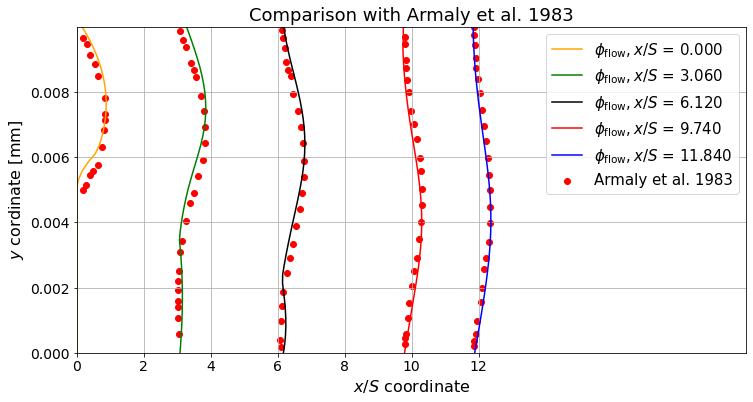

In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def vel_mag(loc):
    mark =  L1 + (loc*4.9*fac)
    div = int((Nx/(L1+L2))*mark)
    #uu = velocity.vector[0].values[div,:Ny-1].numpy('x,y').flatten()
    uu = velocity.vector[0].values.x[div].y[:Ny-1].numpy('x,y').flatten()
    vv = velocity.vector[1].values.x[div].y[:].numpy('x,y').flatten()
    #vv = velocity.vector[1].values[div,:].numpy('x,y').flatten()
    Vel = np.sqrt(uu**2+vv**2)

    return Vel


plt.figure(figsize=(12,6))
font = font_manager.FontProperties(family='Times New Roman', weight='normal', style='normal', size=15)
csfont = {'fontname':'Times New Roman'}


plt.scatter(V_Armaly_0,Y_Armaly_0, label = "Armaly et al. 1983", color='red')
plt.scatter(V_Armaly_3,Y_Armaly_3, color='red')
plt.scatter(V_Armaly_6,Y_Armaly_6, color='red')
plt.scatter(V_Armaly_9,Y_Armaly_9, color='red')
plt.scatter(V_Armaly_11,Y_Armaly_11, color='red')

plt.plot(vel_mag(loc_1)+loc_1,np.linspace(0,H,Ny-1), label = '$\phi_{\mathrm{flow}}, x/S$ = %0.3f' %0.0,color='orange')
plt.plot(vel_mag(loc_2)+loc_2,np.linspace(0,H,Ny-1), label = '$\phi_{\mathrm{flow}}, x/S$ = %0.3f' %3.06,color='green')
plt.plot(vel_mag(loc_3)+loc_3,np.linspace(0,H,Ny-1), label = '$\phi_{\mathrm{flow}}, x/S$ = %0.3f' %6.12,color='black')
plt.plot(vel_mag(loc_4)+loc_4,np.linspace(0,H,Ny-1), label = '$\phi_{\mathrm{flow}}, x/S$ = %0.3f' %9.74,color='red')
plt.plot(vel_mag(loc_5)+loc_5,np.linspace(0,H,Ny-1), label = '$\phi_{\mathrm{flow}}, x/S$ = %0.3f' %11.84,color='blue')



plt.ylim(0,H)

plt.ylabel('$y$ cordinate [mm]',fontsize=16,**csfont)
plt.xlabel('$x/S$ coordinate',fontsize=16, **csfont)
plt.title('Comparison with Armaly et al. 1983', fontsize = 18, **csfont)
plt.legend(loc="upper right", prop=font)
plt.xticks(np.arange(0,14,2))
plt.yticks(np.arange(0,0.01,0.002))
plt.xlim([0, 20])
plt.ylim([0, 0.01])
plt.tick_params(labelsize=14)
plt.grid()
plt.show()

The above figure shows the comparison of $u$-velocity obtained form $\Phi_{\mathrm{flow}}$ with the experiental data of ([Armaly et al. 1983](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/experimental-and-theoretical-investigation-of-backwardfacing-step-flow/6F4D0F1F684A7BAF899EA1CB88B09DEC)). How do the results compare? Do you see a big difference? On the present setting, we observe that $\Phi_{\mathrm{flow}}$ does reasonably well but the solutions can obviously be improved using much finer grid resolution and lower time steps. For instance, try and change $N_x$ = 51 and $N_y$ = 600 with a $\Delta t$ = 0.0001 units and re-run the simulation. 

Text(0.5, 0, '$x/S$ coordinate')

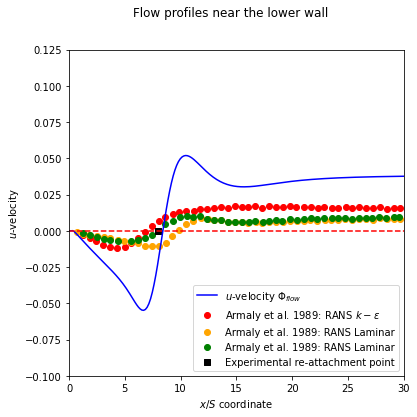

In [ ]:
layer = 0

p_bottom = pressure.values.x[:].y[layer].numpy('x,y').flatten()
x_bottom = pressure.points.vector[0].y[layer].numpy('x,y').flatten()

u_bottom = velocity.vector['x'].values.x[:Nx].y[layer].numpy('x,y').flatten()
v_bottom = velocity.vector['y'].values.x[:Nx].y[layer].numpy('x,y').flatten()

    


def at_centers(self) -> CenteredGrid:

    return CenteredGrid(self, resolution=self.resolution, bounds=self.bounds, extrapolation=self.extrapolation)

Vc = at_centers(velocity)

Vc_mag = math.vec_length(Vc.values).numpy('x,y')

Vc_magb = Vc_mag[:,layer]


fig, axs = plt.subplots(1,1,figsize=(6,6))
fig.suptitle('Flow profiles near the lower wall')


plt.plot(x_bottom/h1,u_bottom,color='blue',label="$u$-velocity $\Phi_{flow}$")
plt.scatter(x_Armaly_rke,u_Armaly_rke,color='red',label="Armaly et al. 1989: RANS $k-\epsilon$")
plt.scatter(x_Armaly_rlam,u_Armaly_rlam,color='orange',label="Armaly et al. 1989: RANS Laminar")
plt.scatter(x_Armaly_llam,u_Armaly_llam,color='green',label="Armaly et al. 1989: RANS Laminar")
plt.scatter(8,0, c = 'black', marker = 's',alpha = None, label="Experimental re-attachment point" )
plt.xlim([0, 30])
plt.ylim([-0.1, 0.125])
plt.legend(loc="lower right")
plt.axhline(y=0.0, color='r', linestyle='--')
plt.ylabel('$u$-velocity')
plt.xlabel('$x/S$ coordinate')



The above cell compares the $u$-velocity distribution just above the lower wall and its comparison with existing data. While we see that the $u$-velocity near the wall is largely over-predicted by $\Phi_{\mathrm{flow}}$, it is primarily due to under-resolved grids. However, interestingly and quite surprisingly, it is found that $\Phi_{\mathrm{flow}}$ does quite well to predict the re-attachment region well. 

Finally, we will show how the overall velocity field compares with the solution computed using [icoFoam](https://cfd-training.com/2019/04/06/backward-facing-step-laminar-flow/)

In [ ]:
vel_u = at_centers(velocity.vector[0])
vel_v = at_centers(velocity.vector[1])

vel_m = (vel_u**2 + vel_v**2)**0.5

vis.plot(vel_m)
vis.show()

<Figure size 432x288 with 0 Axes>

![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/icoFoam.png)